In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class Autoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.elu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

In [4]:
def trainer(model_object, learning_rate=1e-4, batch_size=64, num_epoch=100, n_z=16):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass and report computed losses
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        if epoch % 5 == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [5]:
# Train a model
model = trainer(Autoencoder)

[Epoch 0] recon_loss: 141.059  (2.046 sec/epoch)
[Epoch 5] recon_loss: 96.914  (1.858 sec/epoch)
[Epoch 10] recon_loss: 90.678  (1.835 sec/epoch)
[Epoch 15] recon_loss: 83.062  (1.697 sec/epoch)
[Epoch 20] recon_loss: 87.177  (1.751 sec/epoch)
[Epoch 25] recon_loss: 83.090  (1.623 sec/epoch)
[Epoch 30] recon_loss: 78.696  (1.896 sec/epoch)
[Epoch 35] recon_loss: 75.636  (1.931 sec/epoch)
[Epoch 40] recon_loss: 75.881  (1.803 sec/epoch)
[Epoch 45] recon_loss: 75.924  (1.730 sec/epoch)
[Epoch 50] recon_loss: 70.694  (1.628 sec/epoch)
[Epoch 55] recon_loss: 71.490  (1.928 sec/epoch)
[Epoch 60] recon_loss: 76.264  (1.783 sec/epoch)
[Epoch 65] recon_loss: 74.433  (1.921 sec/epoch)
[Epoch 70] recon_loss: 71.596  (2.003 sec/epoch)
[Epoch 75] recon_loss: 73.180  (1.650 sec/epoch)
[Epoch 80] recon_loss: 70.681  (1.801 sec/epoch)
[Epoch 85] recon_loss: 68.747  (1.858 sec/epoch)
[Epoch 90] recon_loss: 66.893  (1.627 sec/epoch)
[Epoch 95] recon_loss: 74.490  (1.952 sec/epoch)
Done!


In [6]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

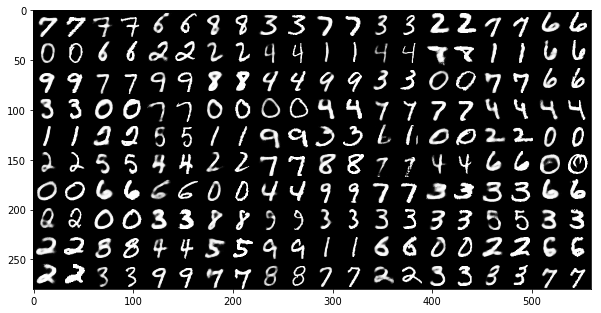

In [7]:
test_reconstruction(model, mnist)

In [8]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2)

[Epoch 0] recon_loss: 184.704  (1.719 sec/epoch)
[Epoch 5] recon_loss: 158.031  (1.804 sec/epoch)
[Epoch 10] recon_loss: 157.155  (2.034 sec/epoch)
[Epoch 15] recon_loss: 150.459  (2.039 sec/epoch)
[Epoch 20] recon_loss: 147.276  (1.767 sec/epoch)
[Epoch 25] recon_loss: 158.301  (2.002 sec/epoch)
[Epoch 30] recon_loss: 138.924  (1.972 sec/epoch)
[Epoch 35] recon_loss: 135.737  (1.857 sec/epoch)
[Epoch 40] recon_loss: 138.053  (1.683 sec/epoch)
[Epoch 45] recon_loss: 128.770  (1.851 sec/epoch)
[Epoch 50] recon_loss: 133.010  (1.977 sec/epoch)
[Epoch 55] recon_loss: 130.531  (1.695 sec/epoch)
[Epoch 60] recon_loss: 137.189  (1.655 sec/epoch)
[Epoch 65] recon_loss: 128.134  (1.960 sec/epoch)
[Epoch 70] recon_loss: 133.022  (1.757 sec/epoch)
[Epoch 75] recon_loss: 133.370  (1.924 sec/epoch)
[Epoch 80] recon_loss: 125.569  (1.899 sec/epoch)
[Epoch 85] recon_loss: 132.990  (2.018 sec/epoch)
[Epoch 90] recon_loss: 127.322  (1.982 sec/epoch)
[Epoch 95] recon_loss: 129.165  (1.928 sec/epoch)
Do

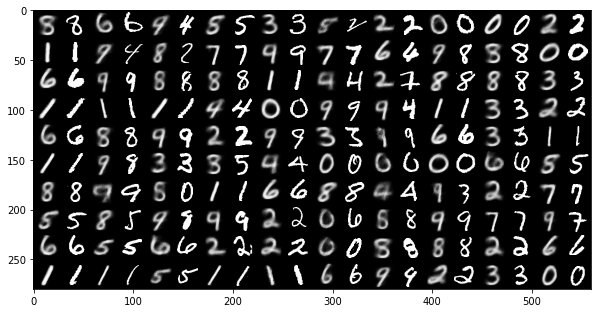

In [9]:
test_reconstruction(model_2d, mnist)

In [10]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [11]:
# Train a model
model = trainer(VariantionalAutoencoder)

[Epoch 0] recon_loss: 182.894  latent_loss: 9.692  total_loss: 192.586  (2.595 sec/epoch)
[Epoch 5] recon_loss: 113.784  latent_loss: 14.704  total_loss: 128.488  (2.470 sec/epoch)
[Epoch 10] recon_loss: 108.452  latent_loss: 17.072  total_loss: 125.523  (2.724 sec/epoch)
[Epoch 15] recon_loss: 101.748  latent_loss: 17.579  total_loss: 119.328  (2.027 sec/epoch)
[Epoch 20] recon_loss: 91.644  latent_loss: 18.083  total_loss: 109.727  (2.467 sec/epoch)
[Epoch 25] recon_loss: 94.685  latent_loss: 18.548  total_loss: 113.234  (2.504 sec/epoch)
[Epoch 30] recon_loss: 87.946  latent_loss: 18.468  total_loss: 106.414  (2.454 sec/epoch)
[Epoch 35] recon_loss: 90.971  latent_loss: 18.891  total_loss: 109.862  (2.588 sec/epoch)
[Epoch 40] recon_loss: 84.645  latent_loss: 18.783  total_loss: 103.428  (2.144 sec/epoch)
[Epoch 45] recon_loss: 85.681  latent_loss: 19.136  total_loss: 104.818  (2.589 sec/epoch)
[Epoch 50] recon_loss: 84.453  latent_loss: 19.142  total_loss: 103.595  (2.524 sec/epoch

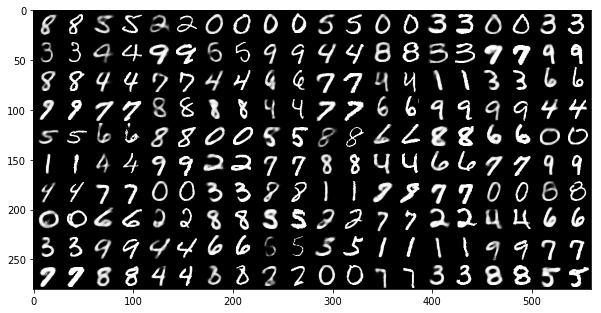

In [12]:
test_reconstruction(model, mnist)

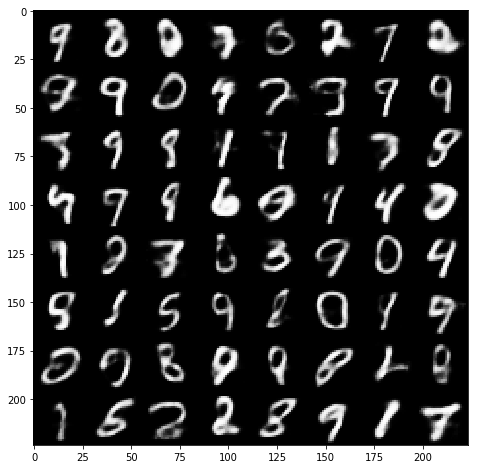

In [13]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [14]:
# Train a model with 2d latent space
model_2d = trainer(VariantionalAutoencoder, n_z=2)

[Epoch 0] recon_loss: 199.729  latent_loss: 4.342  total_loss: 204.071  (2.159 sec/epoch)
[Epoch 5] recon_loss: 167.280  latent_loss: 4.728  total_loss: 172.008  (2.601 sec/epoch)
[Epoch 10] recon_loss: 145.253  latent_loss: 5.516  total_loss: 150.769  (2.589 sec/epoch)
[Epoch 15] recon_loss: 144.056  latent_loss: 5.380  total_loss: 149.436  (2.580 sec/epoch)
[Epoch 20] recon_loss: 148.198  latent_loss: 5.860  total_loss: 154.058  (2.712 sec/epoch)
[Epoch 25] recon_loss: 152.884  latent_loss: 5.783  total_loss: 158.667  (2.075 sec/epoch)
[Epoch 30] recon_loss: 147.188  latent_loss: 5.782  total_loss: 152.970  (2.813 sec/epoch)
[Epoch 35] recon_loss: 144.544  latent_loss: 5.971  total_loss: 150.515  (2.479 sec/epoch)
[Epoch 40] recon_loss: 152.908  latent_loss: 5.965  total_loss: 158.873  (2.542 sec/epoch)
[Epoch 45] recon_loss: 132.893  latent_loss: 6.022  total_loss: 138.916  (2.746 sec/epoch)
[Epoch 50] recon_loss: 136.282  latent_loss: 6.303  total_loss: 142.585  (2.093 sec/epoch)
[

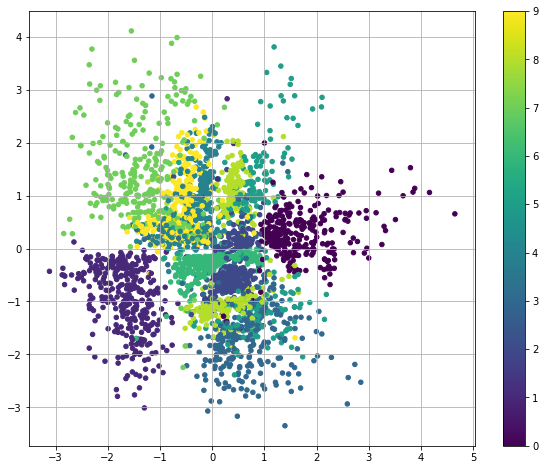

In [15]:
# Test the trained model: transformation
batch = mnist.test.next_batch(3000)
z = model_2d.transformer(batch[0])
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
plt.colorbar()
plt.grid()

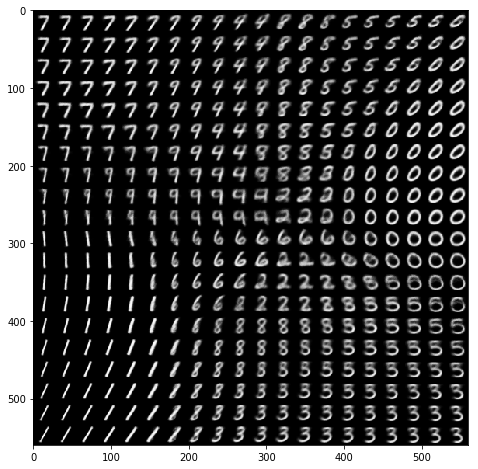

In [16]:
# Test the trained model: transformation
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")